<a href="https://colab.research.google.com/github/Mafaz03/Test-Checkpoints/blob/main/Proximity_simulation_comparison(no%20markdowns).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import time
import numpy as np
from google.colab.patches import cv2_imshow

In [4]:
try:
  import timm
except:
  !pip install timm -q
  import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.1 MB/s eta 0:00:00


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
model_type = "DPT_Large"
midas = torch.hub.load("intel-isl/MiDaS" , model_type)
midas.to(device)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:13<00:00, 103MB/s]


DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [6]:
midas_transforms = torch.hub.load("intel-isl/MiDaS" , "transforms")
transforms = midas_transforms.dpt_transform
transforms

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Compose(
    <function transforms.<locals>.<lambda> at 0x7fd3f30b1000>
    <function transforms.<locals>.<lambda> at 0x7fd3f30b1090>
)

In [51]:
workbench = cv.imread("/content/Workbench.png")
eeve = cv.imread("/content/eeve.png")
cycle = cv.imread("/content/Cycle.png")

workbench = cv.cvtColor(workbench, cv.COLOR_BGR2RGB)
eeve = cv.cvtColor(eeve, cv.COLOR_BGR2RGB)
cycle = cv.cvtColor(cycle, cv.COLOR_BGR2RGB)

size = cycle.shape[:2]

(-0.5, 1919.5, 1079.5, -0.5)

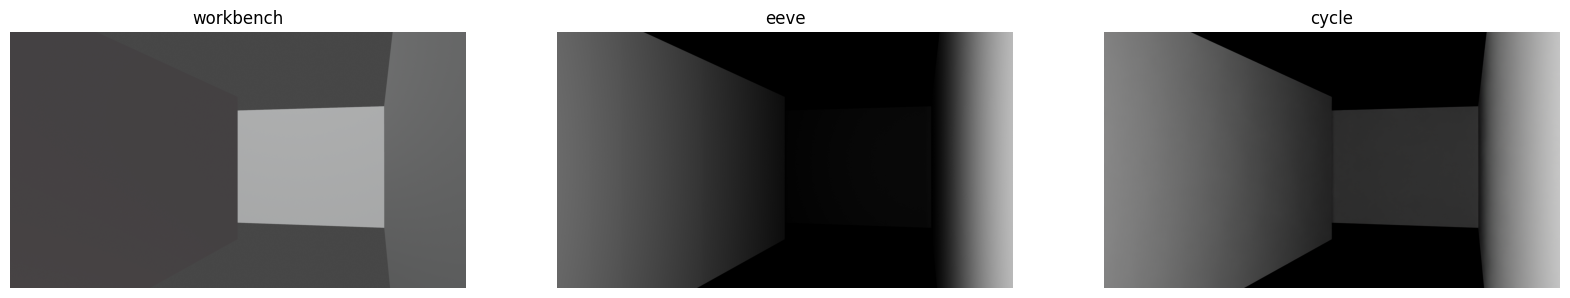

In [52]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(workbench)
plt.title("workbench")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eeve)
plt.title("eeve")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cycle)
plt.title("cycle")
plt.axis("off")


In [53]:
workbench_transformed = transforms(workbench).to(device)
eeve_transformed = transforms(eeve).to(device)
cycle_transformed = transforms(cycle).to(device)

print(workbench_transformed.shape)
print(eeve_transformed.shape)
print(cycle_transformed.shape)

torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])
torch.Size([1, 3, 384, 672])


In [192]:
with torch.no_grad():
  prediction_workbench = midas(workbench_transformed)
  prediction_eeve = midas(eeve_transformed)
  prediction_cycle = midas(cycle_transformed)

  prediction_workbench = torch.nn.functional.interpolate(
      prediction_workbench.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_eeve = torch.nn.functional.interpolate(
      prediction_eeve.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  prediction_cycle = torch.nn.functional.interpolate(
      prediction_cycle.unsqueeze(1),
      size = workbench.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()

  depth_map_workbench = prediction_workbench.cpu().numpy()
  depth_map_workbench = cv.normalize(depth_map_workbench , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_workbench_data = depth_map_workbench
  depth_map_workbench = (depth_map_workbench*255).astype(np.uint8)
  depth_map_workbench = cv.applyColorMap(depth_map_workbench , cv.COLORMAP_MAGMA)

  depth_map_eeve = prediction_eeve.cpu().numpy()
  depth_map_eeve = cv.normalize(depth_map_eeve , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_eeve_data = depth_map_eeve
  depth_map_eeve = (depth_map_eeve*255).astype(np.uint8)
  depth_map_eeve = cv.applyColorMap(depth_map_eeve , cv.COLORMAP_MAGMA)

  depth_map_cycle = prediction_cycle.cpu().numpy()
  depth_map_cycle = cv.normalize(depth_map_cycle , None , 0 , 1 , norm_type = cv.NORM_MINMAX , dtype = cv.CV_64F)
  depth_map_cycle_data = depth_map_cycle
  depth_map_cycle = (depth_map_cycle*255).astype(np.uint8)
  depth_map_cycle = cv.applyColorMap(depth_map_cycle , cv.COLORMAP_MAGMA)

In [193]:
depth_map_workbench = cv.cvtColor(depth_map_workbench, cv.COLOR_BGR2RGB)
depth_map_eeve = cv.cvtColor(depth_map_eeve, cv.COLOR_BGR2RGB)
depth_map_cycle = cv.cvtColor(depth_map_cycle, cv.COLOR_BGR2RGB)

(-0.5, 1919.5, 1079.5, -0.5)

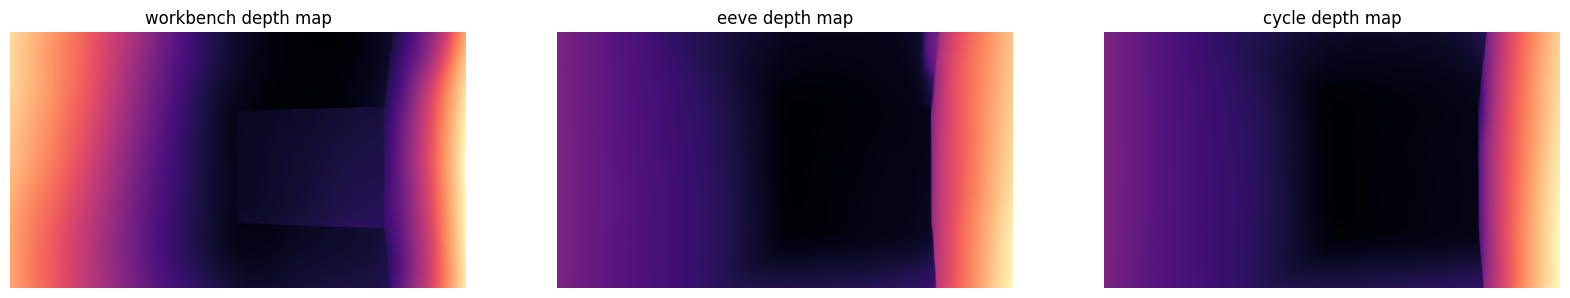

In [194]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(depth_map_workbench)
plt.title("workbench depth map")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(depth_map_eeve)
plt.title("eeve depth map")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(depth_map_cycle)
plt.title("cycle depth map")
plt.axis("off")


In [195]:
depth_map_cycle.shape , depth_map_cycle_data.shape

((1080, 1920, 3), (1080, 1920))

In [196]:
workbench_depth_squeezed = depth_map_workbench[ 600 : 900 ,  0 : size[1] ]
eeve_depth_squeezed = depth_map_eeve[ 600 : 900 ,  0 : size[1] ]
cycle_depth_squeezed = depth_map_cycle[ 600 : 900,  0 : size[1] ]

depth_map_workbench_data = depth_map_workbench_data[ 600 : 900 ,  0 : size[1] ]
depth_map_eeve_data = depth_map_eeve_data[ 600 : 900 ,  0 : size[1] ]
depth_map_cycle_data = depth_map_cycle_data[ 600 : 900 ,  0 : size[1] ]

In [197]:
depth_map_workbench_data

array([[0.86420024, 0.86419041, 0.86436381, ..., 0.99549389, 0.99795091,
        0.99905341],
       [0.86389453, 0.86388506, 0.86405979, ..., 0.99547927, 0.99794719,
        0.99905401],
       [0.86366912, 0.86365977, 0.86383485, ..., 0.99547364, 0.99795247,
        0.99906323],
       ...,
       [0.81298975, 0.81302906, 0.81336155, ..., 0.97692886, 0.97975977,
        0.9810171 ],
       [0.81296848, 0.81300725, 0.81333788, ..., 0.97673628, 0.97957534,
        0.98083543],
       [0.81296363, 0.81299862, 0.81331894, ..., 0.97653783, 0.97939187,
        0.98065783]])

In [198]:
depth_map_eeve_data

array([[0.36466731, 0.36466763, 0.36474194, ..., 0.93229256, 0.93378255,
        0.93441483],
       [0.36466174, 0.36466214, 0.36473674, ..., 0.9324267 , 0.93392724,
        0.93456366],
       [0.36465672, 0.36465712, 0.36473179, ..., 0.93252418, 0.93403329,
        0.93467307],
       ...,
       [0.36146088, 0.3614515 , 0.36150286, ..., 0.97835973, 0.97985663,
        0.98049851],
       [0.36149533, 0.36148456, 0.36153174, ..., 0.97842025, 0.97992406,
        0.9805687 ],
       [0.36153879, 0.36152519, 0.36156458, ..., 0.97849976, 0.98001266,
        0.98066072]])

In [199]:
cycle_depth_squeezed.shape , depth_map_cycle_data.shape

((300, 1920, 3), (300, 1920))

(-0.5, 1919.5, 299.5, -0.5)

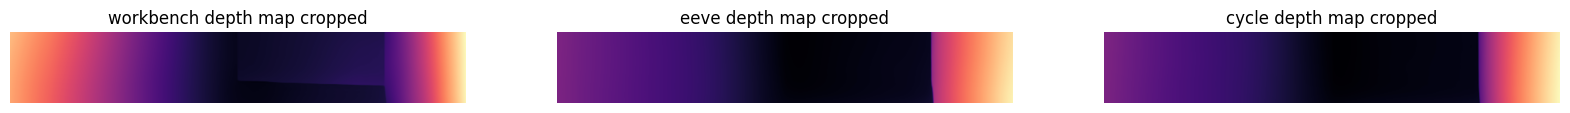

In [200]:
plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(workbench_depth_squeezed)
plt.title("workbench depth map cropped")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(eeve_depth_squeezed)
plt.title("eeve depth map cropped")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cycle_depth_squeezed)
plt.title("cycle depth map cropped")
plt.axis("off")


In [201]:
size_squeezed = workbench_depth_squeezed.shape
size_squeezed

(300, 1920, 3)

In [202]:
def segments(amount : int , width : int) -> list[tuple[int]]:

  slice_list = []
  amount = 10

  sections = width // amount

  beg = sections
  temp = 0
  for batches in range(amount):
    section = sections + temp

    if batches == 0:
      # print( 0 , section)
      slice_list.append((0 , sections))
    else:
      # print(beg , beg + sections)
      slice_list.append((beg , beg + sections))
      beg += sections

  return slice_list

In [203]:
seg = segments(amount = 10 , width = size_squeezed[1])
seg

[(0, 192),
 (192, 384),
 (384, 576),
 (576, 768),
 (768, 960),
 (960, 1152),
 (1152, 1344),
 (1344, 1536),
 (1536, 1728),
 (1728, 1920)]

In [204]:
depth_map_workbench_data.shape , depth_map_eeve_data.shape , depth_map_cycle_data.shape

((300, 1920), (300, 1920), (300, 1920))

0.8644620793573478
0.7042960979261204
0.5116617800884148
0.3061996906497797
0.1481918237403892
0.10702718608634941
0.14625951208037072
0.17454526765421038
0.5151944549264368
0.9990677879994242


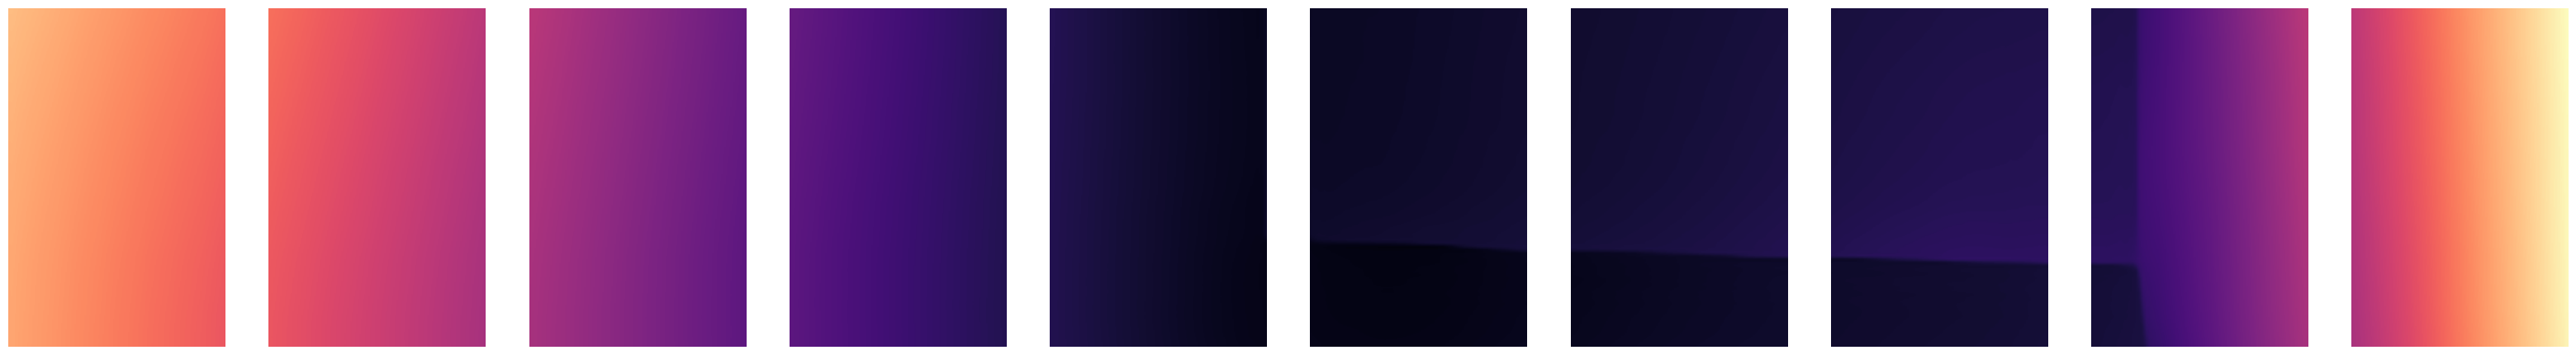

In [205]:
brightest_points_workbench = {}

plt.figure(figsize = (40,45))
for segments in range(len(seg)):
  plt.subplot(1 , len(seg) , segments + 1)
  cropped = workbench_depth_squeezed[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_workbench = depth_map_workbench_data[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_workbench = np.max(cropped_data_workbench)
  brightest_points_workbench[segments + 1] = round(brightest_point_workbench  , 2)
  print(brightest_point_workbench )
  plt.imshow(cropped)
  plt.axis("off")

0.36479002212207257
0.2976726371085963
0.24113457317318207
0.19357307426575102
0.12043152842269846
0.04221611298487227
0.05584017590835501
0.07718830346340783
0.7209946389471384
0.9806607231925433


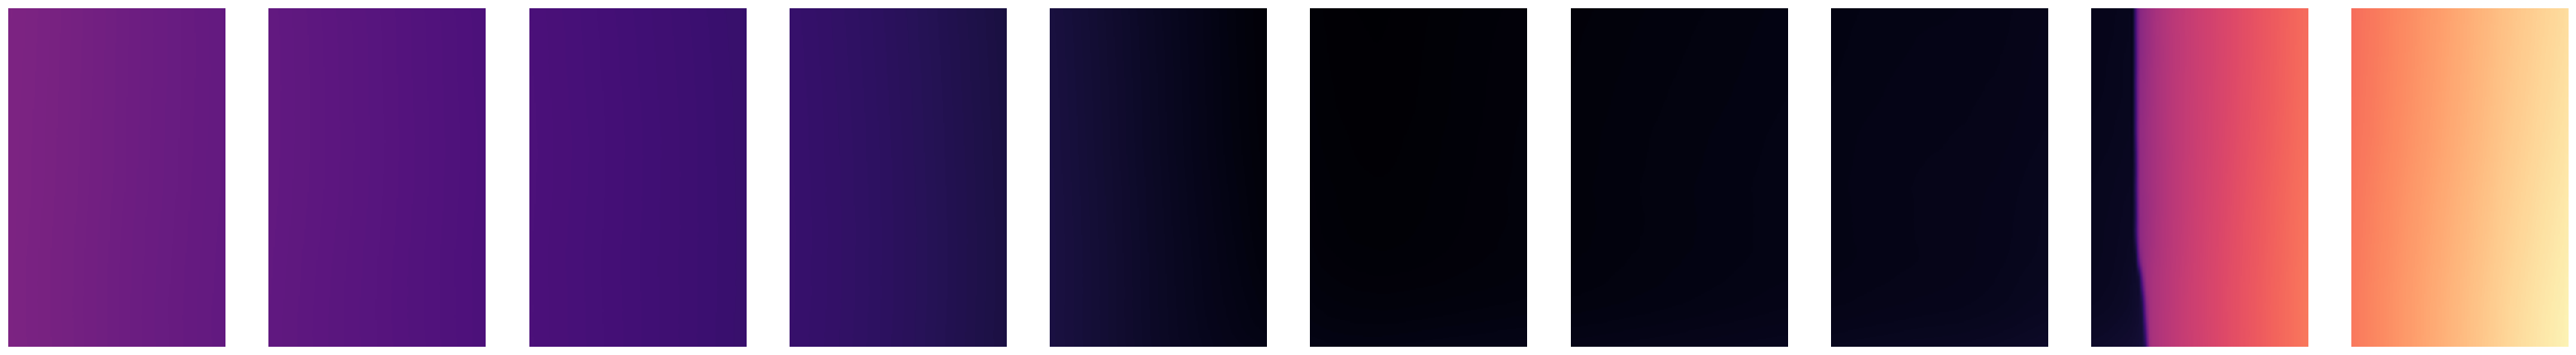

In [206]:
brightest_points_eeve = {}

plt.figure(figsize = (40,45))
for segments in range(len(seg)):
  plt.subplot(1 , len(seg) , segments + 1)
  cropped = eeve_depth_squeezed[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_eeve = depth_map_eeve_data[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_eeve = np.max(cropped_data_eeve)
  brightest_points_eeve[segments + 1] = round(brightest_point_eeve , 2)
  print(brightest_point_eeve)
  plt.imshow(cropped)
  plt.axis("off")

0.3655133608915306
0.28506201143191606
0.22477189780083007
0.18199559659733075
0.10786655799250719
0.040891016401350934
0.049500043184738274
0.06073141946622566
0.6912747414420986
0.9977314806588969


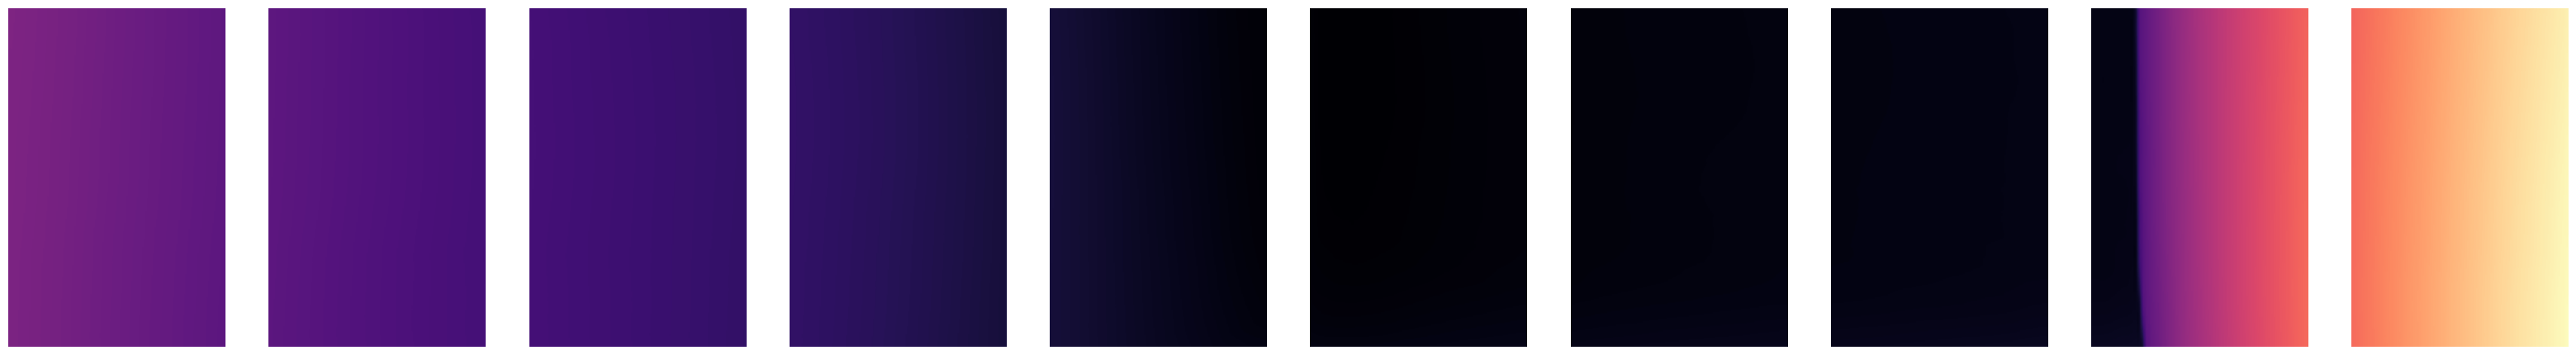

In [207]:
brightest_points_cycle = {}

plt.figure(figsize = (40,45))
for segments in range(len(seg)):
  plt.subplot(1 , len(seg) , segments + 1)
  cropped = cycle_depth_squeezed[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  cropped_data_cycle = depth_map_cycle_data[0 : size_squeezed[0] , seg[0+segments][0] : seg[0+segments][1] ]
  brightest_point_cycle = np.max(cropped_data_cycle)
  brightest_points_cycle[segments + 1] = round(brightest_point_cycle , 2)
  print(brightest_point_cycle)
  plt.imshow(cropped)
  plt.axis("off")

In [208]:
brightest_points_workbench , brightest_points_eeve , brightest_points_cycle

({1: 0.86,
  2: 0.7,
  3: 0.51,
  4: 0.31,
  5: 0.15,
  6: 0.11,
  7: 0.15,
  8: 0.17,
  9: 0.52,
  10: 1.0},
 {1: 0.36,
  2: 0.3,
  3: 0.24,
  4: 0.19,
  5: 0.12,
  6: 0.04,
  7: 0.06,
  8: 0.08,
  9: 0.72,
  10: 0.98},
 {1: 0.37,
  2: 0.29,
  3: 0.22,
  4: 0.18,
  5: 0.11,
  6: 0.04,
  7: 0.05,
  8: 0.06,
  9: 0.69,
  10: 1.0})

Text(0.5, 1.0, 'brightest points cycle')

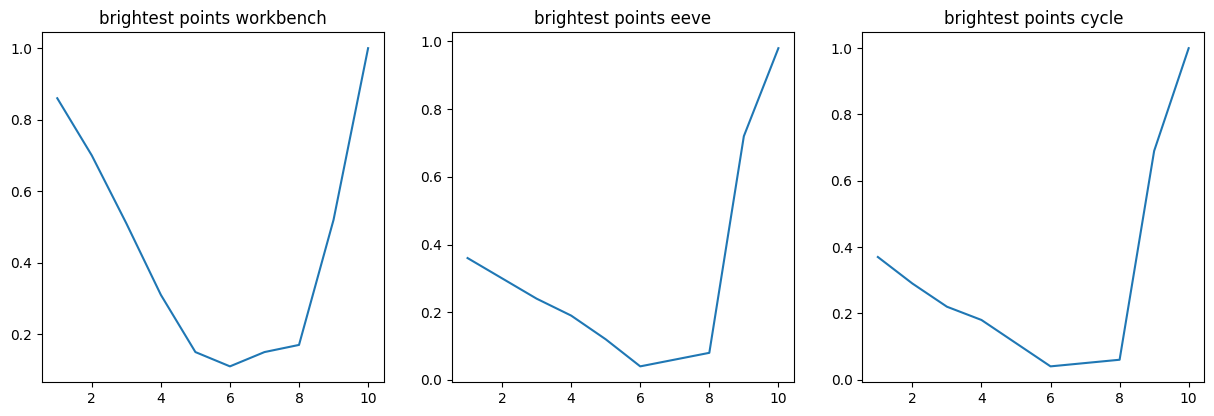

In [209]:
plt.figure(figsize = (15,10))
plt.subplot(2 , 3 , 1)
plt.plot(brightest_points_workbench.keys() , brightest_points_workbench.values())
plt.title("brightest points workbench")

plt.subplot(2 , 3 , 2)
plt.plot(brightest_points_eeve.keys() , brightest_points_eeve.values())
plt.title("brightest points eeve")

plt.subplot(2 , 3 , 3)
plt.plot(brightest_points_cycle.keys() , brightest_points_cycle.values())
plt.title("brightest points cycle")

In [210]:
def polar_plot(brightest_points : dict , title : str , marker):
  ax = plt.subplot(111 , projection = "polar")
  ax.set_rmax(1)
  ax.set_rlabel_position(0)
  degrees= 360/len(brightest_points)
  theta=np.deg2rad(np.arange(0,361,degrees))[1:]
  theta = np.append(theta , theta[0])
  brightest_points[len(brightest_points)+1] = list(brightest_points.values())[0]
  ax.plot(theta , brightest_points.values() , marker = marker)
  plt.title(title)

In [211]:
brightest_points_workbench_normal = {}
for i in range(1 , len(brightest_points_workbench) + 1 ):
  brightest_points_workbench_normal[i] = round(1 - brightest_points_workbench[i] , 2)

brightest_points_eeve_normal = {}
for i in range(1 , len(brightest_points_eeve) + 1 ):
  brightest_points_eeve_normal[i] = round(1 - brightest_points_eeve[i] , 2)

brightest_points_cycle_normal = {}
for i in range(1 , len(brightest_points_cycle) + 1 ):
  brightest_points_cycle_normal[i] = round(1 - brightest_points_cycle[i] , 2)

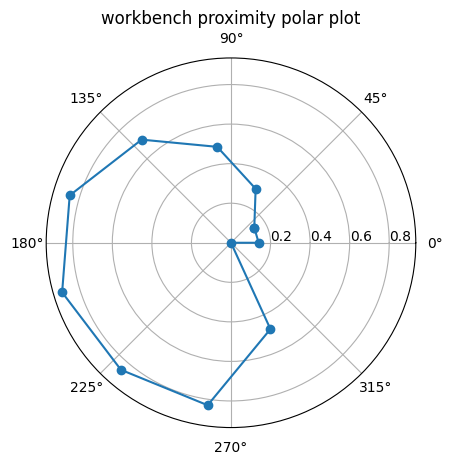

In [215]:
polar_plot(brightest_points_workbench_normal , title = "workbench proximity polar plot" , marker = "o") #closest proximity value is lower

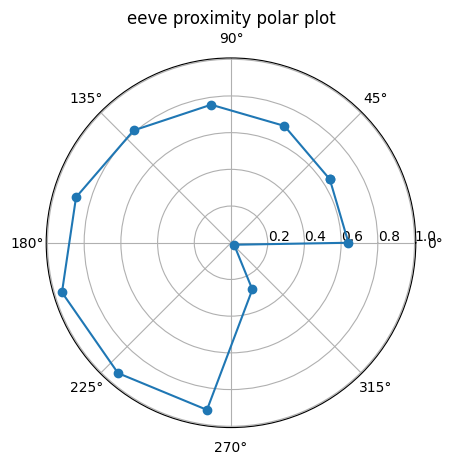

In [216]:
polar_plot(brightest_points_eeve_normal , title = "eeve proximity polar plot" , marker = "o") #closest proximity value is lower

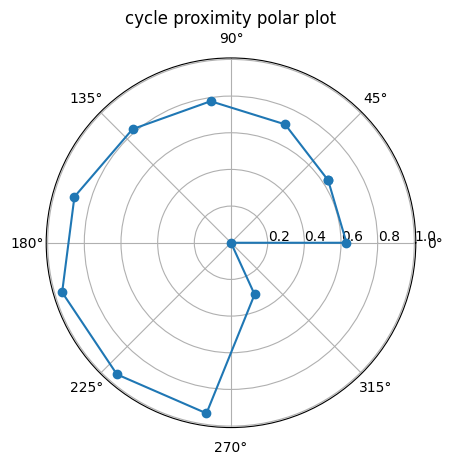

In [217]:
polar_plot(brightest_points_cycle_normal , title = "cycle proximity polar plot" , marker = "o") #closest proximity value is lower